
# **Movie Recommendation System** 
---
### **Authors**
[Dennis Mwanzia](https://github.com/DennisMwanzia), [Amos Kipkirui](https://github.com/Amoskipkirui), [Robert Mbau](https://github.com/robertmbau), [Fiona Kung'u](https://github.com/Fiona-Kungu), [Maureen Kitang'a](https://github.com/ndunge), [Edwin Muhia](https://github.com/rurungamuhia)
 

# 1. Business Understanding


## 1.1 Overview
- MovieXplosion, a new streaming platform wants to improve their user satisfaction. The performance of the platform is dependent on how they can keep user engaged, one way to do this is by providing tailor-made recommendations to the users to drive them to spend more time on the platform.
- The project aims to develop a system that suggests movies to users. We will implement this using collaborative filtering, content-based filtering and hybrid approaches.
## 1.2 Problem Statement
- The current system that the platform employs does not provide suitable recommendations to users which has led to low user engagement, satisfaction and retention. The system also has no way of providing new users with good recommendations and the existing users do not receive tailor-made recommendations.
- The new system aims to bypass these issues and provide relevant recommendations to all users.
## 1.3 Objectives
1. Build a model that provides top 5 recommendations to a user.
2. Develop a system that will address the `cold start` problem for new users.
3. Enhance the recommendation system to provide accurate and relevant movie suggestions based on the user.
4. Evaluate the system performance using appropriate metrics such as `RMSE`.
# 2. Data Understanding
The data used was sourced from [MovieLens](https://grouplens.org/datasets/movielens/latest/), we used the small dataset due to limited computational power. The data contains information about movies, ratings by users and other relevant information.
## 2.1 Data Description
There are several files available with different columns:
1. Movies File
- It contains information about the movies.<br>
`movieId` - Unique identifier for each movie.<br>
`title` - The movie titles.<br>
`genre` - The various genres a movie falls into.<br>
2. Ratings file
- It contains the ratings for the movies by different users.<br>
`userId` - Unique identifier for each user<br>
`movieId` - Unique identifier for each movie.<br>
`rating` - A value between 0 to 5 that a user rates a movie on. A higher rating indicates a higher preference.<br>
`timestamp` - This are the seconds that have passed since Midnight January 1, 1970(UTC)
3. Tags file
- It has user-generated words or short phrases about a movie with the meaning or value being determined ny the specific user.<br>
`userId` - Unique identifier for each user<br>
`movieId` - Unique identifier for each movie.<br>
`tag` - A word or phrase determined by the user.<br>
`timestamp` - This are the seconds that have passed since Midnight January 1, 1970(UTC)
4. Links file
- This are identifiers that can be used to link to other sources of movie data as provide by MovieLens.<br>
`movieId` -  It's an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.<br>
`imdbId` -  It's an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.<br>
`tmdbId` -  is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862. <br>

In [1]:
#importing relevant libraries

#standard libraries
import pandas as pd
import numpy as np


#visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
%matplotlib inline


from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline,KNNWithMeans
from surprise.model_selection import GridSearchCV


In [2]:
# load movies dataset
mov_df = pd.read_csv('Data/movies.csv')
mov_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# loading the ratings dataset
ratings_df = pd.read_csv('Data/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703.0
1,1,3,4.0,964981247.0
2,1,6,4.0,964982224.0
3,1,47,5.0,964983815.0
4,1,50,5.0,964982931.0


In [4]:
# loading links dataset
links_df = pd.read_csv('Data/links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
# loading tags dataset
tags_df = pd.read_csv('Data/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


> We have `userID` and `timestamp` columns in the tags data. Therefore, we dropped the two columns before we merged the entire dataset


In [6]:
# Drop the 'userId' and 'timestamp' columns from the 'merged_dataset'
tags_df = tags_df.drop(['userId', 'timestamp'], axis=1)

# View the updated DataFrame
tags_df.head()


,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA


In [7]:
# Summary statistics for ratings
rating_stats = ratings_df['rating'].describe()
print(rating_stats)

# Percentiles for ratings
percentiles = [0.25, 0.50, 0.75]
rating_percentiles = ratings_df['rating'].quantile(percentiles)
print(rating_percentiles)

count    100844.000000
mean          3.501567
std           1.042507
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64
0.25    3.0
0.50    3.5
0.75    4.0
Name: rating, dtype: float64


The mean movie rating is `3.97` with a standard deviation of `0.97`.<br>
Atleast 50% of the movies were rated `4.0`. This implies that most of the movies produced are liked by the consumers.
Therefore, our streaming platform should aim to feature movies rated atleast `3.5` and above.

# 3. Data preparation
In this phase we will clean our data, check for duplicates and select our data for modeling

### Check for missing data

In [8]:
def check_missing_values(dataset):
    """
    Check for missing values in a dataset.

    Parameters:
        dataset (pandas.DataFrame): The dataset to check for missing values.

    Returns:
        str: A statement indicating if there are missing values or not.
    """
    if dataset.isnull().values.any():
        return "There are missing values in the dataset."
    else:
        return "There are no missing values in the dataset."

In [9]:
check_missing_values(mov_df)

'There are no missing values in the dataset.'

In [10]:
check_missing_values(ratings_df)

'There are missing values in the dataset.'

In [11]:
check_missing_values(links_df)

'There are missing values in the dataset.'

In [12]:
check_missing_values(tags_df)

'There are no missing values in the dataset.'

In [13]:
# We have 8 missing values for tmdbID in Links CSV therefore, we went ahead to investigate them

# Count the number of missing values in the 'tmdbId' column
missing_values = links_df['tmdbId'].isnull().sum()

# Get the rows with missing values in the 'tmdbId' column
missing_rows = links_df[links_df['tmdbId'].isnull()]

# Print the number of missing values and the rows containing them
print("Number of missing values in 'tmdbId' column:", missing_values)
print("Rows with missing values in 'tmdbId' column:")
print(missing_rows)


Number of missing values in 'tmdbId' column: 8
Rows with missing values in 'tmdbId' column:
      movieId  imdbId  tmdbId
624       791  113610     NaN
843      1107  102336     NaN
2141     2851   81454     NaN
3027     4051   56600     NaN
5532    26587   92337     NaN
5854    32600  377059     NaN
6059    40697  105946     NaN
7382    79299  874957     NaN


We merged the movies dataframe and ratings dataframe

In [14]:

ratings_df.drop(columns='timestamp', axis=0, inplace=True)
# merge the two tables on movieId
merged_dataset = pd.merge(mov_df, ratings_df, on='movieId')
merged_dataset.head()


,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [15]:
merged_dataset.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating'], dtype='object')

In [16]:
# Extract the year from the 'Title' column and create a new column 'Year'
merged_dataset['Year'] = merged_dataset['title'].str.extract(r'\((\d{4})\)')

# View the updated DataFrame with the 'Year' column
merged_dataset.head()


,movieId,title,genres,userId,rating,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995


In [17]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100844 entries, 0 to 100843
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100844 non-null  int64  
 1   title    100844 non-null  object 
 2   genres   100844 non-null  object 
 3   userId   100844 non-null  int64  
 4   rating   100844 non-null  float64
 5   Year     100826 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 5.4+ MB


In [18]:
# Drop the year in parenthesis from the title column

merged_dataset['title'] = merged_dataset['title'].str.replace(r'\s*\(\d{4}\)', '')

# View the updated DataFrame
merged_dataset.head()


C:\Users\hp\AppData\Local\Temp\ipykernel_40388\342516581.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  merged_dataset['title'] = merged_dataset['title'].str.replace(r'\s*\(\d{4}\)', '')


,movieId,title,genres,userId,rating,Year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1995


In [19]:
# Count the number of NaN values in the 'Year' column
num_nan_values = merged_dataset['Year'].isna().sum()
print("Number of NaN values in the 'Year' column:", num_nan_values)

Number of NaN values in the 'Year' column: 18


In [20]:
# Replace NaN values with a default value
default_year = 0  # 
merged_dataset['Year'] = merged_dataset['Year'].fillna(default_year).astype(int)


# 4. Exploratory Data Analysis

### 4.1 Distribution of ratings

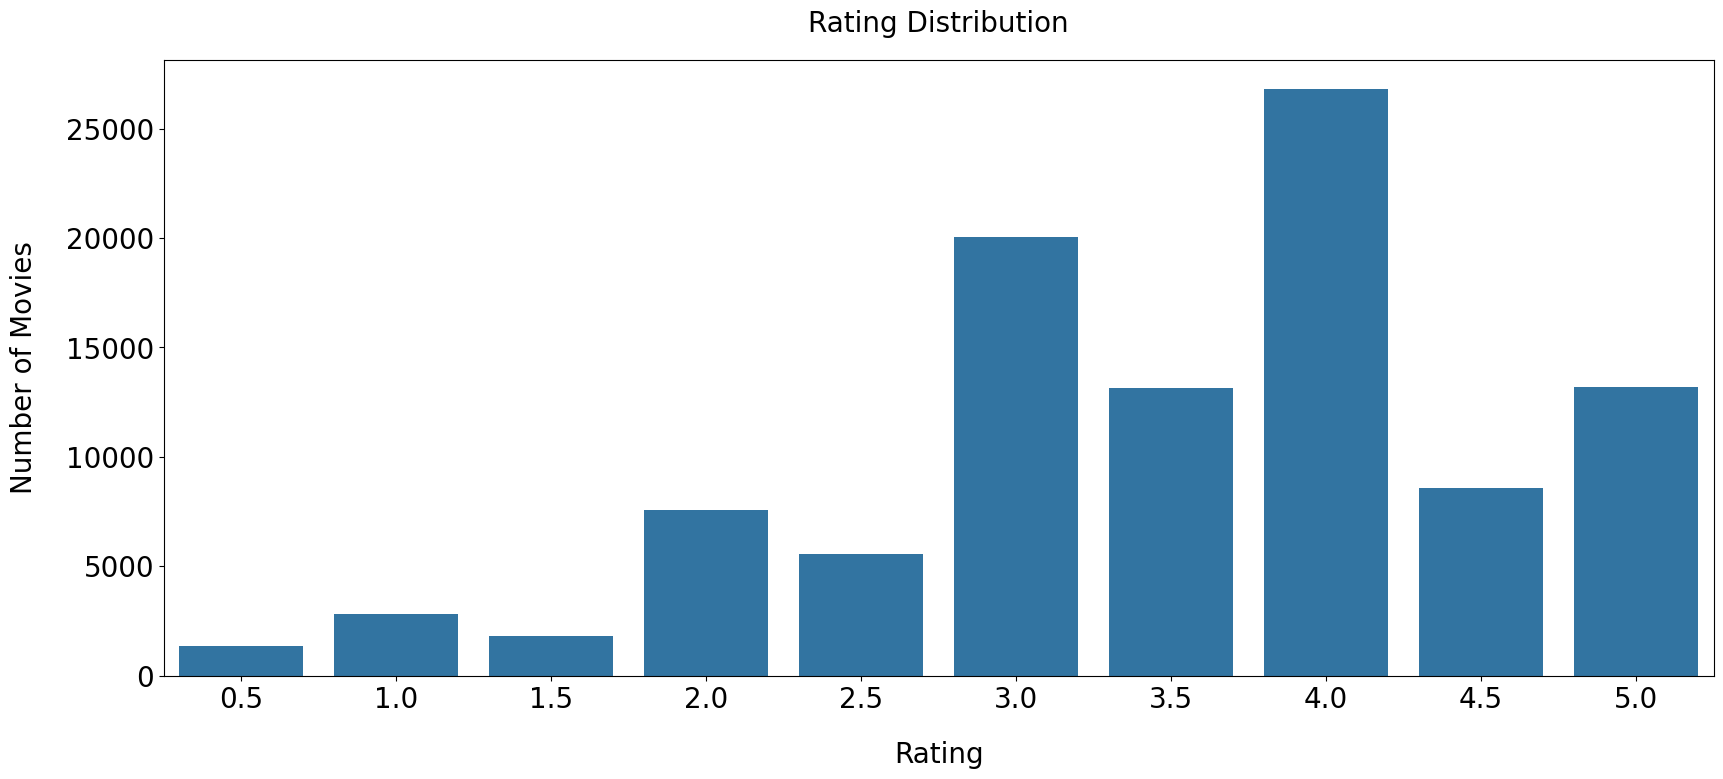

In [21]:
fig, ax = plt.subplots(figsize=(20, 8))

rating_counts = merged_dataset['rating'].value_counts().sort_index()

sns.barplot(x=rating_counts.index,
            y=rating_counts.values,
            color='tab:blue')

plt.title("Rating Distribution", fontsize=20, pad=20)
plt.xlabel("Rating", fontsize=20, labelpad=20)
plt.ylabel("Number of Movies", fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)

plt.show()



The highest rated movies got `5` while the lowest rated was `0.5`.<br>
Most movies were rated at `5` and `4` with a few getting ratings of `0.5` and `1.5`.

### 4.2 Distribution of genres

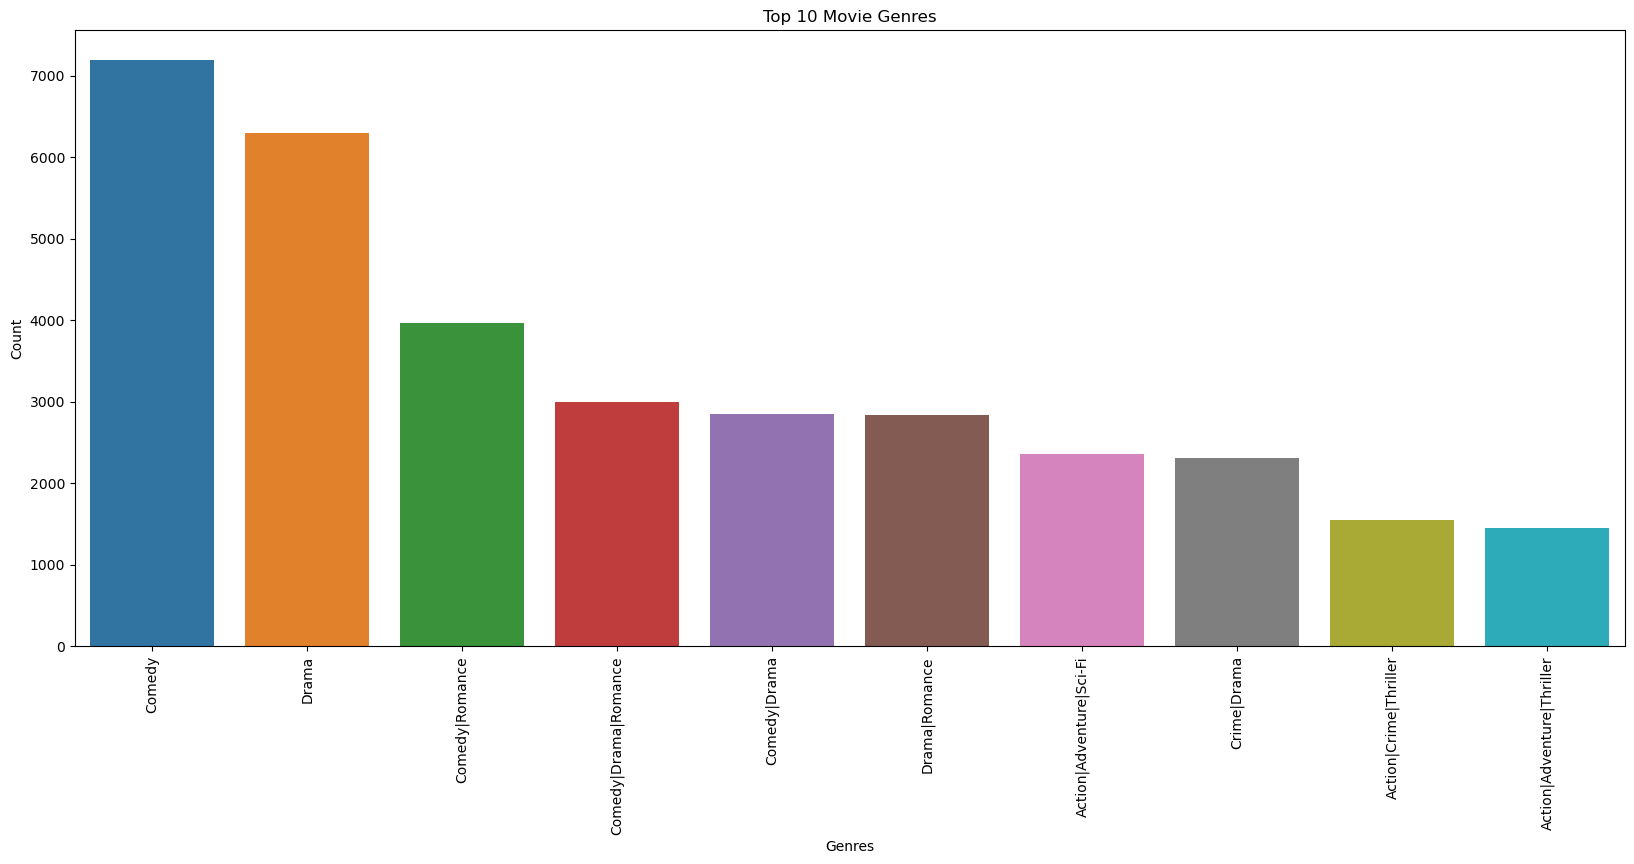

In [22]:
fig, ax = plt.subplots(figsize=(20, 8))  # Increase the figsize values to adjust the size

genres_counts = merged_dataset['genres'].value_counts().head(10)
sns.barplot(x=genres_counts.index, y=genres_counts.values)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Top 10 Movie Genres')
plt.xticks(rotation=90)
plt.show()


Comedy, Drama and Comedy/Romance are the top three performing movie genres

### 4.3 Distribution of movies by decades

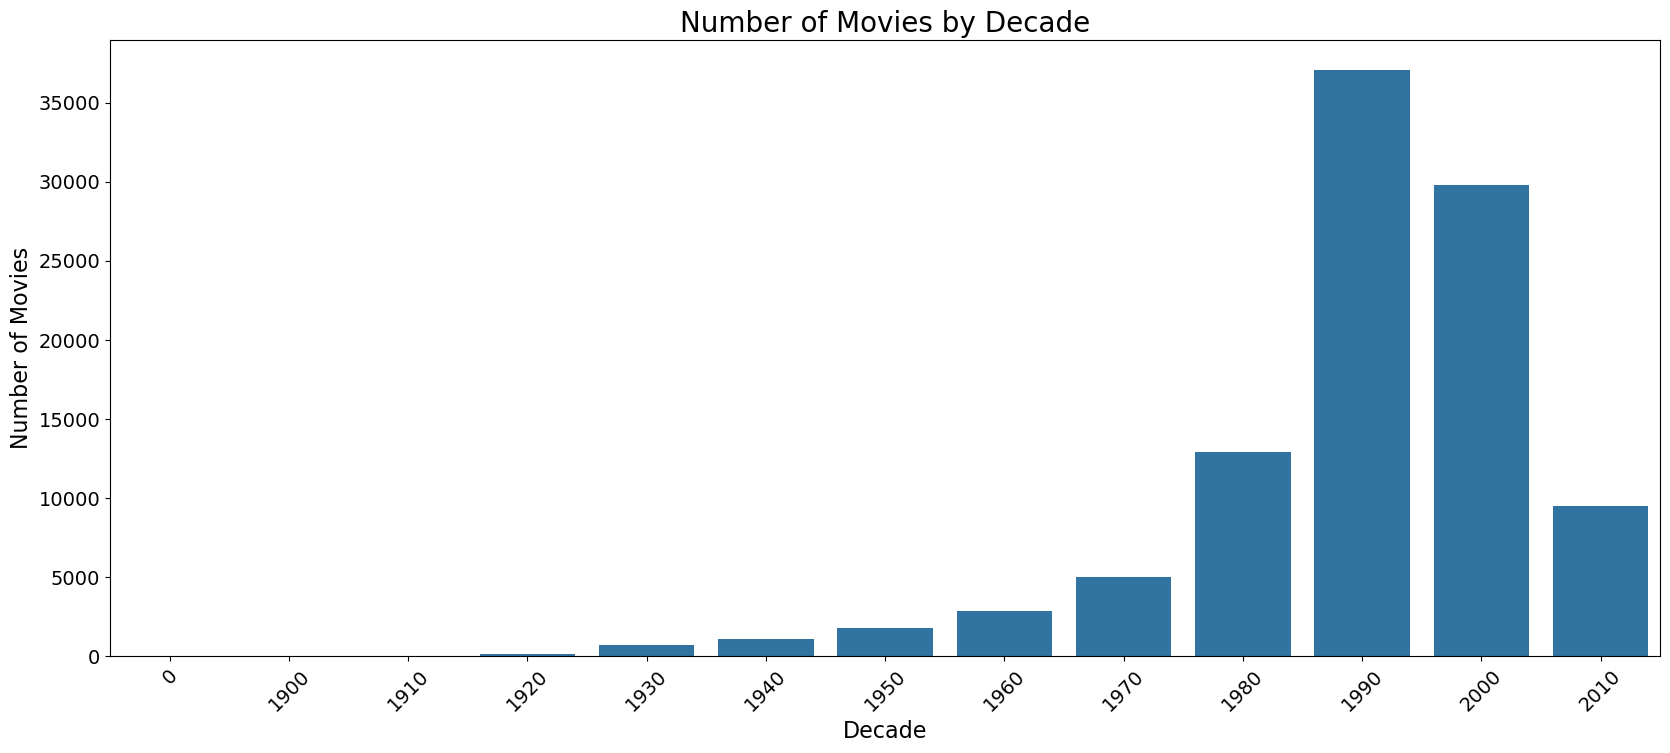

In [23]:
# Group years by decades
merged_dataset['Decade'] = (merged_dataset['Year'] // 10) * 10

fig, ax = plt.subplots(figsize=(20, 8))

sns.countplot(x='Decade',
              data=merged_dataset,
              color='tab:blue')

plt.xlabel("Decade", fontsize=16)
plt.ylabel("Number of Movies", fontsize=16)
plt.title("Number of Movies by Decade", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.grid(False)

# Update x-axis labels with the decade range
decades = np.sort(merged_dataset['Decade'].dropna().unique())
plt.xticks(np.arange(len(decades)), decades)

plt.show()


Movie production increase steadily from 1920s and reached its peak in the 1990s before declining in the new millenium to the same levels as 1980s.

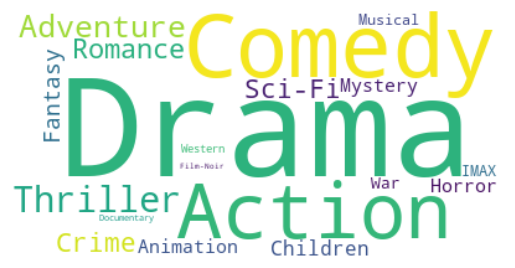

In [24]:
from wordcloud import WordCloud
# Extract the genres column
genres_text = '|'.join(merged_dataset['genres'])
genres_list = genres_text.split('|')

# Create the word frequency dictionary
word_frequency = {}
for genre in genres_list:
    word_frequency[genre] = word_frequency.get(genre, 0) + 1

# Create the WordCloud object
wordcloud = WordCloud(background_color='white')

# Generate the word cloud from the word frequency
wordcloud.generate_from_frequencies(word_frequency)
# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



The genres `Drama`, `Thriller`, `Action` and `Comedy` are the most popular. They are the most appearing genres in the movies.<br>
`Film Noir` and `Documentary` are the least watched genres.

### 4.4 Distribution of ratings by genre

In [25]:
# Count of movies per genre
genre_counts = merged_dataset['genres'].str.split('|', expand=True).stack().value_counts()
print(genre_counts)

print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')

# Relationship between genres and ratings
genre_ratings = merged_dataset.groupby('genres')['rating'].mean()
genre_ratings = genre_ratings.sort_values(ascending=False)

print(genre_ratings)



Drama                 41931
Comedy                39061
Action                30635
Thriller              26452
Adventure             24162
Romance               18125
Sci-Fi                17243
Crime                 16681
Fantasy               11835
Children               9210
Mystery                7674
Horror                 7291
Animation              6989
War                    4859
IMAX                   4145
Musical                4139
Western                1931
Documentary            1219
Film-Noir               870
(no genres listed)       47
dtype: int64
+++++++++++++++++++++++++++++++++++++++++++++++++++++
genres
Comedy|Crime|Drama|Horror                5.0
Adventure|Comedy|Fantasy|Musical         5.0
Animation|Children|Mystery               5.0
Animation|Drama|Sci-Fi|IMAX              5.0
Adventure|Drama|Fantasy|Horror|Sci-Fi    5.0
                                        ... 
Adventure|Children|Comedy|Sci-Fi         0.5
Drama|Fantasy|Sci-Fi|Thriller            0.5
Horror

The genre combinations of `Adventure ,Comedy, Fantasy, Musical` and `Animation,Drama,Sci-Fi,IMAX` got the highest rating of 5 while `Action,Adventure,Children,Drama` got the lowest rating 1.75.

### 4.5 Distribution of ratings by user

In [26]:
user_ratings = merged_dataset.groupby('userId')['rating'].count()
print(user_ratings)

# Top 10 most active users
top_users = user_ratings.nlargest(10)
print(top_users)


userId
1           232
2            29
3            39
4           216
5            44
           ... 
608         831
609          37
610        1302
1000000       4
2000000       4
Name: rating, Length: 612, dtype: int64
userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: rating, dtype: int64


## 5. Modeling

After preparing our data, it was ready to be used for modeling. In recommendation systems, there are three types of models, Collaborative filtering and Content-based and Hybrid filtering. We used Collaborative filtering -KNNWithMeans, KNNBasic and SVD where we picked the best performing model among the three. GridSearch cross-validation was used to get the best hyperparameters for the best performing model.

### 5.1. Creating surprise datasets

In [27]:
# Load ratings dataset
df = pd.read_csv('Data/ratings.csv')
rating_data = df.drop(columns='timestamp')

# Load movies dataset
df_movies = pd.read_csv('Data/movies.csv')

# Create Surprise dataset
reader = Reader()
data = Dataset.load_from_df(rating_data, reader)
dataset = data.build_full_trainset()

### 5.2 Choosing the best model 

In [28]:
from surprise.model_selection import cross_validate

def evaluate_models(data):
    # Split the data into training and test sets
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    # Define a list of models to evaluate
    models = [
        SVD(),
        KNNBasic(sim_options={'name': 'pearson', 'user_based': True}),
        KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
    ]

    # Evaluate each model and store the results
    results = []
    for model in models:
        # Perform cross-validation
        cv_results = cross_validate(model, data, measures=['RMSE'], cv=int(5), verbose=False)

        # Get the average RMSE from cross-validation
        rmse = cv_results['test_rmse'].mean()

        # Store the model and its performance
        results.append({'model': model.__class__.__name__, 'rmse': rmse})

    # Sort the results based on the RMSE in ascending order
    sorted_results = sorted(results, key=lambda x: x['rmse'])

    # Print the results
    for result in sorted_results:
        print(f"Model: {result['model']}, RMSE: {result['rmse']}")

    # Select the best performing model
    best_model = sorted_results[0]['model']
    print(f"Best performing model: {best_model}")

evaluate_models(data)



Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Model: SVD, RMSE: 0.873640276748643
Model: KNNWithMeans, RMSE: 0.8960123312759197
Model: KNNBasic, RMSE: 0.9738514795170616
Best performing model: SVD


#### We found SVD to be the best performing model with a low RMSE. Perform a Gridsearch to further lower its RMSE.

In [48]:
# Perform grid search for SVD
params = {'n_factors': [20, 50, 100], 'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)
best_params = g_s_svd.best_params

print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8691927193585995, 'mae': 0.6681706768653324}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


In [49]:
# Getting the best parameters from the GridSearch
n_factors = best_params['rmse']['n_factors']
reg_all = best_params['rmse']['reg_all']


#### 5.3 Train the best performing model with the best parameters to increase its accuracy

In [50]:
# Train SVD model with the best RMSE parameters
svd = SVD(n_factors=n_factors, reg_all=reg_all)
svd.fit(dataset)

#### 5.4 Write a function to get explicit user ratings for movies

In [31]:
def movie_rater(movie_df, num, genre=None):
    userID = 1000  # Set a default userID for new users
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen, or type "escape" to see personalized recommendations:\n')
        if rating == 'n':
            continue
        elif rating.lower() == 'escape':
            return None  # Indicates the user wants personalized recommendations
        else:
            rating_one_movie = {'userId': userID, 'movieId': movie['movieId'].values[0], 'rating': float(rating)}
            rating_list.append(rating_one_movie)
            num -= 1
    return rating_list

#### 5.4 Function to recommend popular movies

In [32]:
# Function to recommend popular movies
def recommend_popular_movies(ratings_df, movies_df, genre, num_recommendations=5):
    # Calculate average ratings and number of ratings for each movie
    average_ratings = ratings_df.groupby('movieId')['rating'].mean()
    num_ratings = ratings_df.groupby('movieId')['rating'].count()

    # Create a DataFrame with movie popularity metrics
    popularity_df = pd.DataFrame({'average_rating': average_ratings, 'num_ratings': num_ratings})

    # Sort movies based on popularity metrics (e.g., average rating and number of ratings)
    popularity_df = popularity_df.sort_values(by=['average_rating', 'num_ratings'], ascending=False)

    # Filter movies by genre (if provided)
    if genre:
        popular_movies = movies_df[movies_df['genres'].str.contains(genre)]
        popular_movies = popular_movies.merge(popularity_df, on='movieId', how='left')
    else:
        popular_movies = popularity_df.merge(movies_df, on='movieId', how='left')

    # Get the top-rated or most popular movies from the sorted DataFrame
    top_movies = popular_movies.head(num_recommendations)

    # Return the recommended movies
    return top_movies['title']


In [33]:
# Load ratings and movies data
ratings_df = pd.read_csv('Data/ratings.csv')
movies_df = pd.read_csv('Data/movies.csv')

### 5.5 Prompt the user to enter their user ID

In [34]:
user_id = input('Enter your user ID: ')

# Convert user_id to int data type
user_id = int(user_id)

#### 5.5.1 Checking if the user already exists in the ratings dataset or is a new user

In [35]:
# Check if the user already exists in the ratings dataset
if user_id in ratings_df['userId'].unique():
    # User is an existing user
    print(f"Welcome back, User {user_id}!")

    # Get user ratings using the movie_rater function
    user_rating = movie_rater(movies_df, 4, genre='Comedy')

    if user_rating is None:
        # User wants personalized recommendations without providing any ratings
        print("\nPersonalized movie recommendations based on your existing ratings:")

        # Extract the user's ratings from the ratings dataframe
        user_ratings = ratings_df[ratings_df['userId'] == user_id]

        # Group the ratings by movie and calculate the average rating for each movie
        movie_ratings = user_ratings.groupby('movieId')['rating'].mean().reset_index()

        # Merge movie ratings with movie metadata
        personalized_movies = movie_ratings.merge(movies_df, on='movieId', how='left')

        # Sort the movies based on the average rating
        personalized_movies = personalized_movies.sort_values(by='rating', ascending=False)

        # Get the top 5 movie recommendations
        recommendations = personalized_movies['title'].head(5)

        # Print the recommendations
        for idx, rec in enumerate(recommendations):
            print(f"Recommendation #{idx+1}: {rec}")

    else:
        # User has provided ratings
        # Add the new ratings to the original ratings DataFrame
        user_ratings = pd.DataFrame(user_rating)
        new_ratings_df = pd.concat([ratings_df, user_ratings], ignore_index=True)

        # Update the ratings dataframe with the new user ID
        new_ratings_df.loc[new_ratings_df['userId'].isna(), 'userId'] = user_id

        # Define the reader
        reader = Reader(rating_scale=(1, 5))

        # Load the data from the DataFrame
        new_data = Dataset.load_from_df(new_ratings_df[['userId', 'movieId', 'rating']], reader)

        # Train the SVD model with the updated ratings
        svd = SVD()
        svd.fit(new_data.build_full_trainset())

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in movies_df['movieId'].unique():
            predicted_rating = svd.predict(user_id, movie_id).est
            predictions.append((movie_id, predicted_rating))

        # Sort the predicted ratings
        ranked_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

        # Print the top 5 movie recommendations for the user
        print("\nTop 5 movie recommendations based on your ratings:")
        for idx, rec in enumerate(ranked_predictions[:5]):
            title = movies_df.loc[movies_df['movieId'] == rec[0], 'title'].values[0]
            print(f"Recommendation #{idx+1}: {title}")

        # Update the ratings dataframe with the new user ID
        ratings_df = new_ratings_df

else:
    # New user without any ratings
    print("Welcome, New User!")

    # Get user ratings using the movie_rater function
    user_rating = movie_rater(movies_df, 4, genre='Comedy')

    if user_rating is None:
        # User wants popular movie recommendations
        print("\nPopular movie recommendations based on genre:")

        genre = input("Enter a genre to get recommendations based on that (leave blank for all genres): ")
        recommendations = recommend_popular_movies(ratings_df, movies_df, genre, num_recommendations=5)
        for idx, rec in enumerate(recommendations):
            print(f"Recommendation #{idx+1}: {rec}")

    else:
        # User has provided ratings
        # Add the new ratings to the original ratings DataFrame
        user_ratings = pd.DataFrame(user_rating)
        new_ratings_df = pd.concat([ratings_df, user_ratings], ignore_index=True)

        # Update the ratings dataframe with the new user ID
        new_ratings_df.loc[new_ratings_df['userId'].isna(), 'userId'] = user_id

        # Define the reader
        reader = Reader(rating_scale=(1, 5))

        # Load the data from the DataFrame
        new_data = Dataset.load_from_df(new_ratings_df[['userId', 'movieId', 'rating']], reader)

        # Train the SVD model with the updated ratings
        svd = SVD()
        svd.fit(new_data.build_full_trainset())

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in movies_df['movieId'].unique():
            predicted_rating = svd.predict(user_id, movie_id).est
            predictions.append((movie_id, predicted_rating))

        # Sort the predicted ratings
        ranked_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

        # Print the top 5 movie recommendations for the user
        print("\nTop 5 movie recommendations based on your ratings:")
        for idx, rec in enumerate(ranked_predictions[:5]):
            title = movies_df.loc[movies_df['movieId'] == rec[0], 'title'].values[0]
            print(f"Recommendation #{idx+1}: {title}")

        # Update the ratings dataframe with the new user ID
        ratings_df = new_ratings_df
        



Welcome back, User 3!
      movieId                   title          genres
7256    74450  Valentine's Day (2010)  Comedy|Romance
      movieId         title                genres
5364     8948  Alfie (2004)  Comedy|Drama|Romance
      movieId                   title          genres
1227     1629  MatchMaker, The (1997)  Comedy|Romance
      movieId                      title              genres
6836    61323  Burn After Reading (2008)  Comedy|Crime|Drama

Top 5 movie recommendations based on your ratings:
Recommendation #1: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Recommendation #2: Godfather, The (1972)
Recommendation #3: American Splendor (2003)
Recommendation #4: The Lair of the White Worm (1988)
Recommendation #5: Galaxy of Terror (Quest) (1981)
